# Analyze Nek5000 workflow expansion

## Global Configurations

In [1]:
notebook_name = "lbann-cosmoflow"

In [2]:
parquet_folder="/p/gpfs1/iopp/parquet_app_logs/lbann-cosmoflow/nodes-32"

In [3]:
num_nodes = 32

## System Imports

In [4]:
import socket
import os
import time
from time import sleep

## Create Dask Cluster for analysis

### Dask Job Queue Imports

In [5]:
import dask_jobqueue
from dask_jobqueue import LSFCluster

/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/dask_jobqueue/core.py:17: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/dask_jobqueue/core.py:17: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import parse_bytes


### Dask Worker configuration
When we use dask for analysis, we need to consider the type of analysis. In this case we plan to utilize dask dataframes for analysis that is typically memory intensive. Therefore, we allocate the whole memory per node and use only 4 worker processes per node. More worker processes reduce memory available per worker resulting in frequent memory swap from filesystem.

In [6]:
node_memory = 256 # node memory in GB
n_workers_per_node = 4 # number of worker processes per node
worker_time = "02:00" # job time per node for worker
worker_queue = "pdebug" # queue to be used per worker
n_workers = 16 # number of workers to be used for analysis

Other configurations we can compute

In [7]:
host = socket.gethostname()
dashboard_address = '{}:8787'.format(socket.gethostname())
memory = '{}GB'.format(node_memory/n_workers_per_node)
job_extra = ['-nnodes 1', 
             '-G asccasc', 
             '-q {}'.format(worker_queue), 
             '-W {}'.format(worker_time), 
             '-o {}.log'.format(notebook_name), 
             '-e {}.log'.format(notebook_name)]

### Create Dask Cluster 

In [8]:
cluster = LSFCluster(cores = n_workers_per_node,processes=n_workers_per_node, memory='{}GB'.format(node_memory), 
                     header_skip=['-n ','-R','-M', '-P', '-W 00:30'], 
                     job_extra = job_extra, 
                     use_stdin=True, host = host,dashboard_address = dashboard_address)
if cluster:
    print("Created Cluster with job script\n {}".format(cluster.job_script()))

{'cls': <class 'distributed.scheduler.Scheduler'>, 'options': {'protocol': 'tcp://', 'interface': None, 'host': 'lassen708', 'dashboard_address': 'lassen708:8787', 'security': None}}
Created Cluster with job script
 #!/usr/bin/env bash

#BSUB -J dask-worker
#BSUB -nnodes 1
#BSUB -G asccasc
#BSUB -q pdebug
#BSUB -W 02:00
#BSUB -o lbann-cosmoflow.log
#BSUB -e lbann-cosmoflow.log
JOB_ID=${LSB_JOBID%.*}

/usr/workspace/iopp/.conda/envs/jupyter/bin/python -m distributed.cli.dask_worker tcp://192.168.66.200:38447 --nthreads 1 --nprocs 4 --memory-limit 59.60GiB --name name --nanny --death-timeout 60



### Dask Analysis Imports

In [9]:
import dask.dataframe as dd
from dask.distributed import wait, progress
from dask.diagnostics import ProgressBar
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

### Create Dask Client

In [10]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.LSFCluster
Dashboard: http://192.168.66.200:8787/status,
Dashboard: http://192.168.66.200:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://192.168.66.200:38447,Workers: 0
Dashboard: http://192.168.66.200:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Spawn cluster nodes

In [11]:
cluster.scale(n_workers)

In [12]:
val = len(client.scheduler_info()["workers"])
while ((client.status == "running") and ( val < n_workers_per_node)):
    print("Waiting for workers completed {} of {}".format(val, n_workers), end="\r")
    sleep(1.0)
    val = len(client.scheduler_info()["workers"])
print("\n{} workers started".format(len(client.scheduler_info()["workers"])))

Waiting for workers completed 0 of 16
6 workers started


## Analysis Utility Functions

### Progress Bars

In [13]:
pbar = ProgressBar()
pbar.register()

### Timer functions

In [14]:
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer

### Threading process 

In [15]:
def thread_print(string):
    print(f'{string}\n', end='')
def thread_process( num_ranks, func, start=0, list_range=[], workers=40):
    with ThreadPoolExecutor(max_workers = workers) as executor:
        if len(list_range) == 0:
            list_range = range(start, num_ranks) 
        future_gen = {executor.submit(func, rank): rank for rank in list_range}
        for future in concurrent.futures.as_completed(future_gen):
            rank = future_gen[future]
            try:
                data = future.result()
            except Exception as exc:
                thread_print('%r generated an exception: %s' % (rank, exc))
            else:
                thread_print('%r data computed' % (rank))

### Application Logs in Parquet format

## Initial Boostrapping

### Read Application logs into dask dataframe

In [16]:
ddf = dd.read_parquet("{}/*.parquet".format(parquet_folder), engine="pyarrow-dataset")

In [17]:
print("Dask dataframe is split into {} partitions".format(ddf.npartitions))

Dask dataframe is split into 126 partitions


In [18]:
print("Columns present in dataset")
print(ddf.columns)

Columns present in dataset
Index(['index', 'rank', 'thread_id', 'cat', 'tstart', 'tend', 'func_id',
       'level', 'arg_count', 'args_1', 'args_2', 'args_3', 'args_4', 'args_5',
       'args_6', 'args_7', 'args_8', 'args_9', 'args_10'],
      dtype='object')


In [19]:
ddf.head()

,index,rank,thread_id,cat,tstart,tend,func_id,level,arg_count,args_1,args_2,args_3,args_4,args_5,args_6,args_7,args_8,args_9,args_10
0,1,0,2099194032,2,0.295049,3.254283,MPI_Comm_dup,0,3,MPI_COMM_WORLD,0-0,0,,,,,,,
1,2,0,2099194032,0,3.253641,3.253651,open,1,3,/dev/shm/job2154496201-35619-OMPI_COLL_IBM-0-c...,557250,384,,,,,,,
2,3,0,2099194032,0,3.253686,3.253690,open,1,2,/dev/shm/job2154496201-35619-OMPI_COLL_IBM-0-c...,557058,,,,,,,,
3,4,0,2099194032,0,3.253701,3.253709,ftruncate,1,2,/dev/shm/job2154496201-35619-OMPI_COLL_IBM-0-c...,2691072,,,,,,,,
4,5,0,2099194032,0,3.253717,3.253719,close,1,1,/dev/shm/job2154496201-35619-OMPI_COLL_IBM-0-c...,,,,,,,,,


#### Only keep level zero from MPI and FTRACE but keep all levels for I/O

In [20]:
ddf = ddf[(ddf['level'] == 0) | ddf['cat'].isin([0,1,3])]
#ddf = ddf.persist()

### Split dataframe into I/O, MPI, and trace

In [21]:
io_ddf = ddf[ddf['cat'].isin([0,1,3])]
exclude_dirs = [".pyc", "/usr","/g/g92/haridev/.nccl.conf"]
for directory in exclude_dirs:
    io_ddf = io_ddf[~io_ddf['args_1'].str.contains(directory)]
#io_ddf[rank] = io_ddf[rank].persist()
mpi_ddf = ddf[ddf['cat'] == 2]
#mpi_ddf[rank] = mpi_ddf[rank].persist()
trace_ddf = ddf[ddf['cat'] == 4]

### Preload the I/O dataframe for faster analysis

In [22]:
io_ddf = io_ddf.persist()
result = wait(io_ddf)

### Check I/O interfaces used by application

In [23]:
interfaces = io_ddf['func_id'].unique().compute()
print(interfaces)

0                          open
1                     ftruncate
2                         close
3                        unlink
4                       fopen64
5                        fclose
6                     faccessat
7                       readdir
8                      closedir
9                        access
10                      __xstat
11                        write
12                     readlink
13                         read
14                        fread
15                       open64
16                        fcntl
17                      opendir
18                      H5Fopen
19                   __fxstat64
20                      pread64
21                   __lxstat64
22                    __xstat64
23                     H5Dopen2
24                 H5Dget_space
25    H5Sget_simple_extent_dims
26                     H5Dclose
27                    H5Pcreate
28             H5Pset_fapl_mpio
29             H5Pset_dxpl_mpio
30                MPI_File_open
31      

Only POSIX interface is used in this application

### Set duration of I/O events

In [24]:
io_ddf['duration'] = io_ddf['tend'] - io_ddf['tstart']

In [25]:
negetive_duration = io_ddf[io_ddf['duration'] < 0]['duration'].count().compute()
print("Application Profiler has stored {} negetive values".format(negetive_duration))

Application Profiler has stored 0 negetive values


### Create conditions for filtering
Even though this application doesnt have MPI or STDIO we have all the conditions here. This is to make sure we cover other apps as well.

In [26]:
open_condition = io_ddf['func_id'].str.contains("open")
mpi_condition = io_ddf['func_id'].str.contains("MPI")
read_condition = io_ddf['func_id'].isin(["read", "pread", "pread64", "readv"])
fread_condition = io_ddf['func_id'].isin(["fread"])
close_condition = io_ddf['func_id'].str.contains('close')
write_condition = io_ddf['func_id'].isin(["write", "pwrite", "pwrite64","writev"])
fwrite_condition = io_ddf['func_id'].isin(["fwrite"])
readdir_condition = io_ddf['func_id'].isin(["readdir"])

### Extract Filename from each row.
This simplifies analysis later on as we can filter recorder per rank and per file to understand access pattern information.

In [27]:
io_ddf['filename'] = ""
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & ~mpi_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & mpi_condition, io_ddf['args_2'])
io_ddf['filename'] = io_ddf['filename'].mask(close_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(read_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fread_condition, io_ddf['args_4'])
io_ddf['filename'] = io_ddf['filename'].mask(write_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fwrite_condition, io_ddf['args_4'])

Some filename has redundent forward slashes

In [28]:
io_ddf['filename'] = io_ddf['filename'].str.replace('//','/')

### Filter recorder which have read and write operations and which have metadata.
We assume that there is only two types of operation in I/O read/write and metadata.

In [29]:
io_ddf_read_write = io_ddf[read_condition | write_condition].compute()
io_ddf_metadata = io_ddf[~read_condition & ~write_condition].compute()

### Build size and count to understand I/O on the io_ddf_read_write dataframe

In [30]:
open_condition = io_ddf_read_write['func_id'].str.contains("open")
mpi_condition = io_ddf_read_write['func_id'].str.contains("MPI")
read_condition = io_ddf_read_write['func_id'].isin(["read", "pread", "pread64", "readv"])
fread_condition = io_ddf_read_write['func_id'].isin(["fread"])
close_condition = io_ddf_read_write['func_id'].str.contains('close')
write_condition = io_ddf_read_write['func_id'].isin(["write", "pwrite", "pwrite64","writev"])
fwrite_condition = io_ddf_read_write['func_id'].isin(["fwrite"])
readdir_condition = io_ddf_read_write['func_id'].isin(["readdir"])

In [31]:
io_ddf_read_write['size'] = 0
io_ddf_read_write['count'] = 1
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(read_condition , io_ddf_read_write['args_3'])
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(fread_condition, io_ddf_read_write['args_3'])
io_ddf_read_write['count'] = io_ddf_read_write['count'].mask(fread_condition, io_ddf_read_write['args_2'])
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(write_condition, io_ddf_read_write['args_3'])
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(fwrite_condition, io_ddf_read_write['args_3'])
io_ddf_read_write['count'] = io_ddf_read_write['count'].mask(fwrite_condition, io_ddf_read_write['args_2'])

#### Corner cases

In [32]:
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(readdir_condition , "0")
io_ddf_read_write['count'] = io_ddf_read_write['count'].mask(readdir_condition , "1")

#### Set Datatypes
This is needed as by default args are string from which they are set.

In [33]:
io_ddf_read_write = io_ddf_read_write.astype({'size': 'int32','count': 'int32'})

#### Compute Final Size
After this point we do not use count field.

In [34]:
io_ddf_read_write['size'] = io_ddf_read_write['size'] * io_ddf_read_write['count']

### Calculate Bandwidth in MB/s for I/O operations.
Durations might be incorrect or equal to zero due to profilers resolution issues. Therefore, we do bandwidth calculations for only correct durations.

In [35]:
correct_dur = ((io_ddf_read_write['tend'] - io_ddf_read_write['tstart']) > 0)
io_ddf_read_write['bandwidth'] = 0
io_ddf_read_write['bandwidth'] = io_ddf_read_write['bandwidth'].mask(correct_dur, io_ddf_read_write['size']*1.0/(io_ddf_read_write['tend'] - io_ddf_read_write['tstart'])/1024.0/1024.0)

### Calculate all relevent filenames in the application
The profiler might see jsrun files and other irrelevant internal files which we filter here.

In [36]:
all_filenames = io_ddf[io_ddf['filename'].str.contains('/p/gpfs1')]['filename'].unique().compute()

In [37]:
print("The application accesses {} files across all ranks".format(len(all_filenames)))

The application accesses 49664 files across all ranks


### Distribution of Transfer Size and Bandwidth in the application
The transfer size is given by the size column in bytes and the bandwidth is shown in MB/s

In [38]:
io_ddf_read_write[['size', 'bandwidth']].describe()

,size,bandwidth
count,2.190837e+06,2.190837e+06
mean,7.489909e+05,9.172911e-01
std,1.004627e+06,6.635606e+00
min,8.000000e+00,0.000000e+00
25%,3.280000e+02,0.000000e+00
50%,5.120000e+02,0.000000e+00
75%,2.097152e+06,0.000000e+00
max,2.097152e+06,2.560000e+02


### Preload the I/O dataframe for faster analysis

In [39]:
io_ddf = io_ddf.persist()
result = wait(io_ddf)

## Application Analysis

### Num Ranks

In [40]:
num_ranks = io_ddf_read_write['rank'].nunique()
print("Number of ranks in application {}".format(num_ranks))

Number of ranks in application 126


### Total I/O amount

In [41]:
total_io = io_ddf_read_write.groupby('func_id')['size'].sum()/1024.0/1024.0/1024.0
print("Total I/O in application {} GB".format(total_io.sum()))
print("Total I/O per operation in application {} GB".format(total_io))

Total I/O in application 1528.2230294644833 GB
Total I/O per operation in application func_id
pread      1528.219065
pread64       0.000884
read          0.000168
write         0.002912
Name: size, dtype: float64 GB


### I/O per rank

In [42]:
io_ddf_read_write.groupby(['rank', 'func_id'])['size'].sum()

rank  func_id
0     pread      1.302384e+10
      pread64    7.536000e+03
      read       4.523000e+03
      write      2.523200e+04
1     pread      1.302288e+10
                     ...     
126   write      2.099200e+04
127   pread      1.302288e+10
      pread64    7.536000e+03
      read       2.630000e+02
      write      1.656000e+04
Name: size, Length: 504, dtype: float64

**rank 0 performs 100x more I/O than others. Also every other process reads data where as only rank 0 writes it.**

<AxesSubplot:xlabel='rank'>

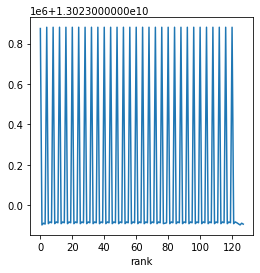

In [43]:
io_per_rank_gb = io_ddf_read_write.groupby(['rank'])['size'].sum()
io_per_rank_gb.plot(kind='line',figsize=(4,4))

### Operations Per Rank

<AxesSubplot:xlabel='rank'>

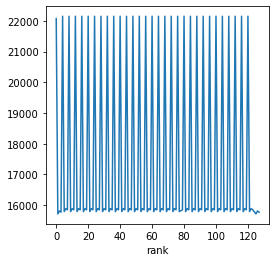

In [44]:
io_per_rank_gb = io_ddf_read_write.groupby('rank')['count'].sum()
io_per_rank_gb.plot(kind='line',figsize=(4,4))

**Also rank 0 performs 2000x more operations than other ranks.**

### Average I/O Time per process

In [45]:
time_per_rank = io_ddf.groupby('rank')['duration'].sum().compute()

In [46]:
print("time per process: Average {} sec, Max {} sec, and Min {} sec".format(time_per_rank.mean(), time_per_rank.max(), time_per_rank.min()))

time per process: Average 315.5113525390625 sec, Max 400.69744873046875 sec, and Min 272.14599609375 sec


<AxesSubplot:xlabel='rank'>

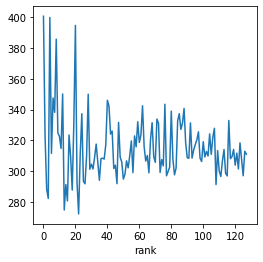

In [47]:
time_per_rank.plot(kind='line',figsize=(4,4))

Most time is spent by rank 0.

### Compute Time

#### Convert trace dataframe into memory.

In [48]:
trace_ddf_local = trace_ddf

#### Calculate duration for trace values

In [49]:
trace_ddf_local['duration'] = trace_ddf_local['tend'] - trace_ddf_local['tstart']

In [50]:
trace_ddf_local['duration'].describe().compute()

count    4.403382e+07
mean     2.625627e+01
std      1.028949e+02
min     -9.843750e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.300000e+02
Name: duration, dtype: float64

In [51]:
negetive_durations = trace_ddf_local[trace_ddf_local['duration'] < 0]['duration'].count().compute()
print("Profiler stored {} negetive rows".format(negetive_durations))

Profiler stored 53237 negetive rows


In [52]:
time_per_rank = trace_ddf_local.groupby('rank')['duration'].sum().compute()

In [53]:
print("Time per process: Average {} sec, Max {} sec, and Min {} sec".format(time_per_rank.mean(), time_per_rank.max(), time_per_rank.min()))

Time per process: Average 9175906.0 sec, Max 18367626.0 sec, and Min 2876931.5 sec


<AxesSubplot:xlabel='rank'>

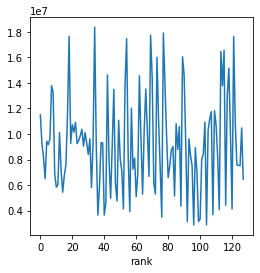

In [54]:
time_per_rank.plot(kind='line',figsize=(4,4))

**No compute trace available**

## Job Time

In [55]:
job_time = ddf['tend'].max().compute()

In [56]:
print("Job Time in Application {} sec".format(job_time))

Job Time in Application 12023159.0 sec


The application run for a long time includes initialization.

## Job Intensity

In [57]:
total_compute = trace_ddf_local.groupby('rank')['duration'].sum().max().compute()
total_io = io_ddf.groupby('rank')['duration'].sum().max().compute()
print("I/O Time: {} sec Compute Time: {} sec".format(total_io, total_compute))

I/O Time: 400.69744873046875 sec Compute Time: 18367626.0 sec


In [58]:
io_intensity=total_io/(total_io + total_compute)
comp_intensity=total_compute/(total_io + total_compute)

In [59]:
print("I/O intensity: {}, Compute intensity: {}".format(io_intensity, comp_intensity))

I/O intensity: 2.1814942635407022e-05, Compute intensity: 0.9999781850573646


**Application is not compute intensive as only 4 second of the overall time (i.e. 668 sec) is spent on I/O**

### I/O Transfer Size Distribution

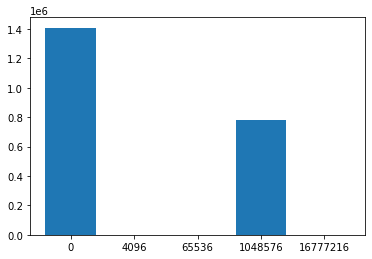

In [60]:
file_df_temp = io_ddf_read_write
size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
size_ranges_str = []
for range_val in size_ranges:
    size_ranges_str.append(str(range_val))
max_range = len(size_ranges)
request_size = [0]*len(size_ranges)
for i, val in enumerate(size_ranges):
    #print(i, max_range)
    if i < max_range - 1:
        request_size[i] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                       (file_df_temp['size'].lt(size_ranges[i+1]))]['size'].count()
    else:
        request_size[i] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['size'].count()

#print(request_size)
plt.bar(size_ranges_str, request_size)
#file_sizes = file_df_temp['size'].to_numpy() / 1024.0 /1024.0
#plt.hist(file_sizes, bins=100)
plt.show()

**Application performs a lot of small I/O <=4 KB and reads 16MB**

### Distribution of request sizes per rank
We need this as we see most I/O occurs by rank 0

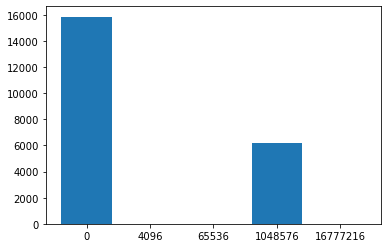

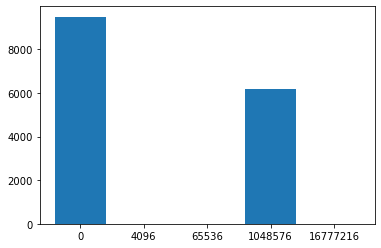

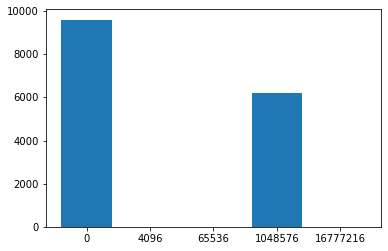

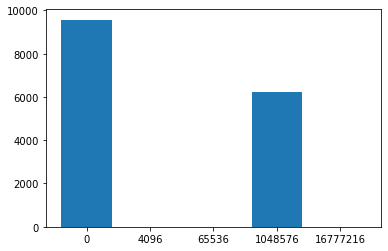

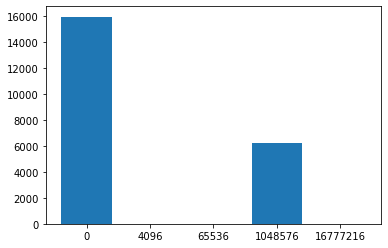

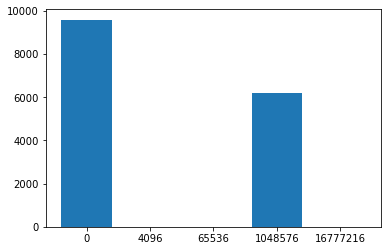

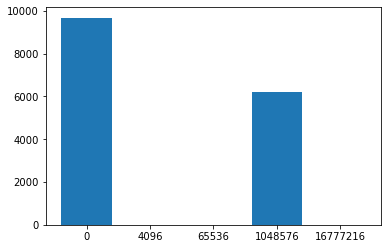

In [61]:
selected_ranks = [0,1,2,3,4,5,6]
for rank in selected_ranks:
    file_df_temp = io_ddf_read_write[io_ddf_read_write['rank'] == rank]
    size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
    size_ranges_str = []
    for range_val in size_ranges:
        size_ranges_str.append(str(range_val))
    max_range = len(size_ranges)
    request_size = [0]*len(size_ranges)
    for i, val in enumerate(size_ranges):
        #print(i, max_range)
        if i < max_range - 1:
            request_size[i] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                           (file_df_temp['size'].lt(size_ranges[i+1]))]['size'].count()
        else:
            request_size[i] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['size'].count()

    #print(request_size)
    plt.bar(size_ranges_str, request_size)
    #file_sizes = file_df_temp['size'].to_numpy() / 1024.0 /1024.0
    #plt.hist(file_sizes, bins=100)
    plt.show()

**The application uses a transfer size of 4K (used by rank 0) and 16MB (used by other ranks)**

### Distribution of Bandwidth achived by application

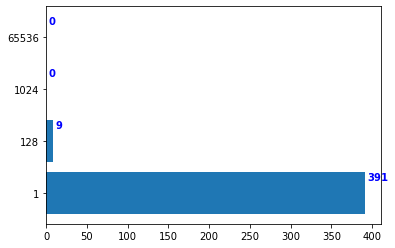

In [62]:
bw_ranges = [1, 128, 1024, 1024*64]
bw_ranges_str = []
for range_val in bw_ranges:
    bw_ranges_str.append(str(range_val))
max_range = len(bw_ranges)
request_bw = [0]*len(bw_ranges)
for i, val in enumerate(bw_ranges):
    #print(i, max_range)
    if i < max_range - 1:
        request_bw[i] = file_df_temp[(file_df_temp['bandwidth'].ge(val)) & 
                                       (file_df_temp['bandwidth'].lt(bw_ranges[i+1]))]['size'].count()
    else:
        request_bw[i] = file_df_temp[(file_df_temp['bandwidth'] >=bw_ranges[i])]['size'].count()
fig, ax = plt.subplots()
ax.barh(bw_ranges_str, request_bw)
for i, v in enumerate(request_bw):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
plt.show()

In [63]:
request_bw

[391, 9, 0, 0]

In [64]:
percentage_bw = np.array(request_bw)*100/np.sum(request_bw)
percentage_bw

array([97.75,  2.25,  0.  ,  0.  ])

- 40% of the overall I/O got a bandwidth of 128 MB/s per process.
- 35% achieve a low bandwidth of 64GB/s

### Number of files read/written

In [65]:
all_filenames = io_ddf[io_ddf['filename'].str.contains('/p/gpfs1')]['filename'].unique().compute()
print("The application accesses {} files".format(len(all_filenames)))
#print(all_filenames[:8],all_filenames[-8:])

The application accesses 49664 files


### I/O Operations by Application

In [66]:
io_ddf.groupby('func_id')['func_id'].count().compute()

func_id
H5Dclose                      391482
H5Dget_space                  195930
H5Dopen2                      391482
H5Dread                       391104
H5Fclose                      195552
H5Fopen                       195930
H5Pcreate                        756
H5Pset_dxpl_mpio                 378
H5Pset_fapl_mpio                 378
H5Screate_simple              195552
H5Sget_simple_extent_dims     195930
H5Sselect_hyperslab           195552
MPI_File_close                195552
MPI_File_get_size              48112
MPI_File_open                 195552
MPI_File_read_at             2147968
__fxstat                         440
__fxstat64                       756
__lxstat64                       378
__xstat                        50380
__xstat64                        658
access                       5276186
close                         660815
closedir                        3528
faccessat                      67160
fclose                        138827
fcntl                         

**As there are 1280 ranks in total, Most I/O is performed by rank 0 rest of them do less I/O**

### IO Operations per rank

In [67]:
io_ddf.groupby(['rank','func_id'])['func_id'].count().compute()[:32]

rank  func_id                  
0     H5Dclose                      3107
      H5Dget_space                  1555
      H5Dopen2                      3107
      H5Dread                       3104
      H5Fclose                      1552
      H5Fopen                       1555
      H5Pcreate                        6
      H5Pset_dxpl_mpio                 3
      H5Pset_fapl_mpio                 3
      H5Screate_simple              1552
      H5Sget_simple_extent_dims     1555
      H5Sselect_hyperslab           1552
      MPI_File_close                1552
      MPI_File_get_size             1552
      MPI_File_open                 1552
      MPI_File_read_at             21728
      __fxstat                         4
      __fxstat64                       6
      __lxstat64                       3
      __xstat                       1570
      __xstat64                      283
      access                       41907
      close                         5218
      closedir           

In [68]:
io_ddf.groupby(['rank','func_id'])['func_id'].count().compute()[128:160]

rank  func_id                  
3     H5Fclose                      1552
      H5Fopen                       1555
      H5Pcreate                        6
      H5Pset_dxpl_mpio                 3
      H5Pset_fapl_mpio                 3
      H5Screate_simple              1552
      H5Sget_simple_extent_dims     1555
      H5Sselect_hyperslab           1552
      MPI_File_close                1552
      MPI_File_open                 1552
      MPI_File_read_at             15520
      __fxstat                         3
      __fxstat64                       6
      __lxstat64                       3
      __xstat                         18
      __xstat64                        3
      access                       41843
      close                         5271
      closedir                        28
      faccessat                      552
      fclose                        1048
      fcntl                          171
      fopen64                       1161
      fread              

**These confirm our hypothesis that most I/O is performed by rank 0 rest of them do less I/O**

### Bandwidth per request distribution
We calculate the achived bandwidth per request size.

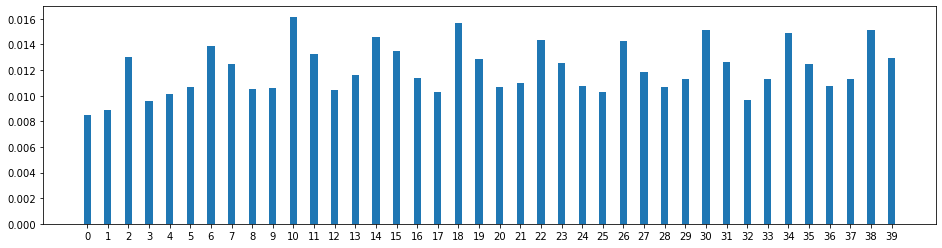

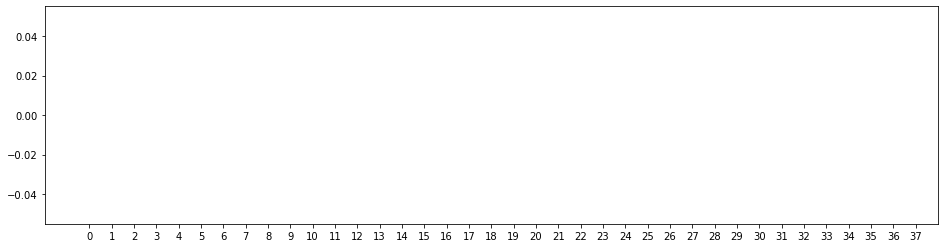

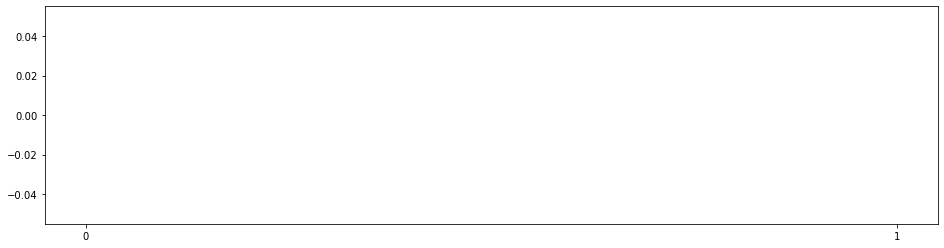

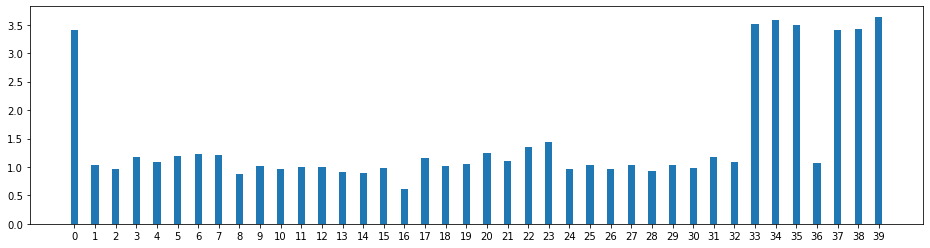

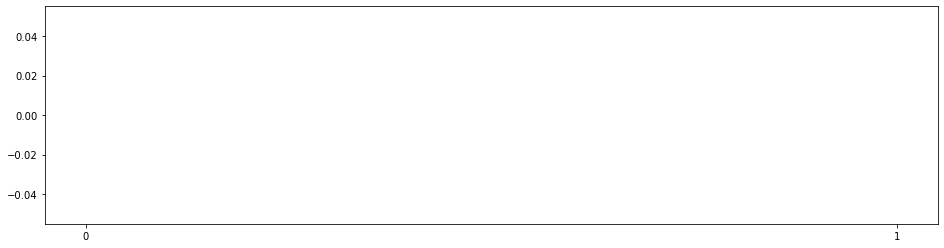

No handles with labels found to put in legend.


In [69]:
ranks = range(40)
ranks_str = []
for rank in ranks:
    ranks_str.append(str(rank))
size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
request_size = [[]]*len(size_ranges)
for i, val in enumerate(size_ranges):
    request_size[i] = [0]*len(ranks)
    for j,rank in enumerate(ranks):
        
        file_df_temp = io_ddf_read_write[io_ddf_read_write['rank'] == rank]
        max_range = len(size_ranges)
        if i < max_range - 1:
            request_size[i][j] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                           (file_df_temp['size'].lt(size_ranges[i+1]))]['bandwidth'].mean()
        else:
            request_size[i][j] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['bandwidth'].mean()
#fig, ax = plt.subplots(figsize=(16,4))
#width = 0.35
#plt.figure()
for i, val in enumerate(size_ranges):
    plt.figure(figsize=(16,4))
    rects1 = plt.bar(ranks_str, request_size[i], 0.35, label=str(i))
    plt.show()
ax.legend()

fig.tight_layout()

plt.show()

**Larger Request sizes have larger bandwidth. However as 4KB write dominates the application I/O we see small bandwidth overall**

### Overlapping of Compute and I/O

In [70]:
io_ddf.groupby('rank')['thread_id'].nunique().describe().compute()

count    126.000000
mean       5.396825
std        0.727509
min        4.000000
25%        5.000000
50%        6.000000
75%        6.000000
max        6.000000
Name: thread_id, dtype: float64

#### No additional threads means I/O is synchronous to compute. I.e. all I/O is unoverlapped.

### Timeline
The timeline analysis shows how each rank performs I/O over the runtime of the applications

In [71]:
time_step=100000 # in seconds

#### Request Size Timeline

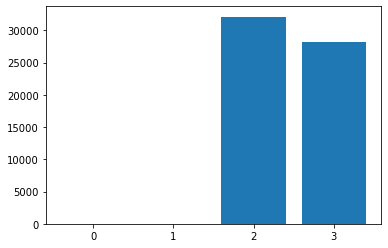

<BarContainer object of 117 artists>

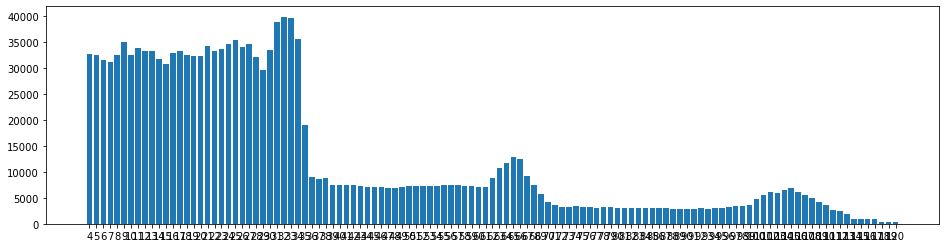

In [72]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
values_str = []
timeline_ts = [0]*len(values_int)
prev = 0
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i])
    timeline_ts[i] = io_ddf_read_write[contains]['size'].sum()/1024.0/1024.0
    prev = values[i]
plt.bar(values_str[:4], timeline_ts[:4])
plt.show()
plt.figure(figsize=(16,4))
plt.bar(values_str[4:], timeline_ts[4:])

**Most of the I/O (20GB) is performed in first 40 seconds and rest 1GB happens in the rest of the time**

### Time Timeline

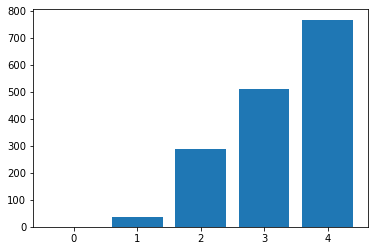

<BarContainer object of 116 artists>

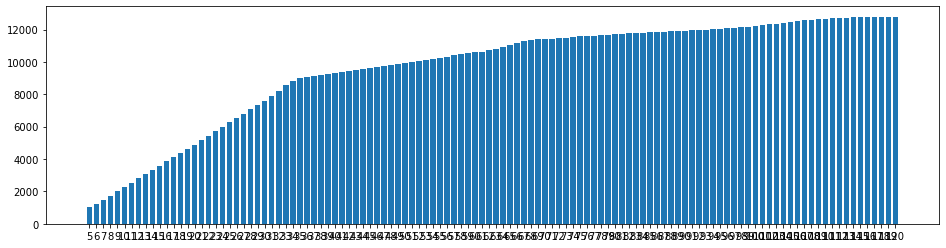

In [73]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
values_str = []
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i])
    timeline_ts[i] = io_ddf_read_write[contains]['duration'].sum()
    prev = i
plt.bar(values_str[:5], timeline_ts[:5])
plt.show()
plt.figure(figsize=(16,4))
plt.bar(values_str[5:], timeline_ts[5:])

#### Bandwidth Timeline

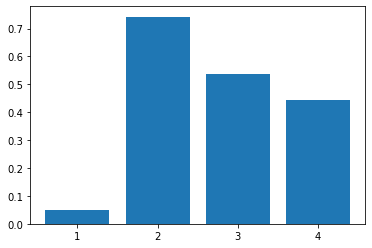

<BarContainer object of 116 artists>

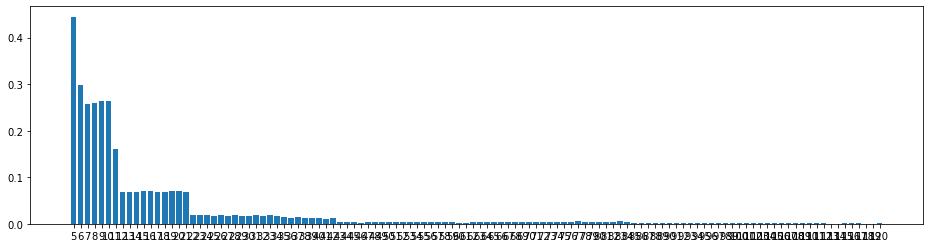

In [74]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
values_str = []
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i])
    timeline_ts[i] = io_ddf_read_write[contains]['bandwidth'].mean()/10.0
    prev = values[i]
plt.bar(values_str[:5], timeline_ts[:5])
plt.show()
plt.figure(figsize=(16,4))
plt.bar(values_str[5:], timeline_ts[5:])

**This supports our previous observation as the bandwidth is the measure of I/O performance of the application.**

#### Bandwidth Timeline Per Rank

rank 0


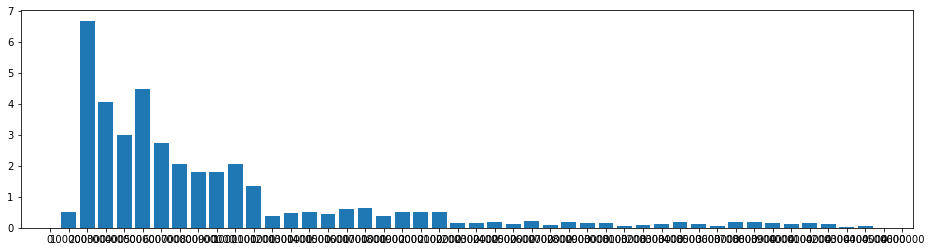

rank 4


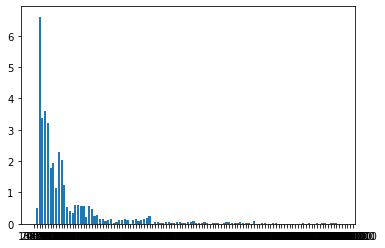

rank 8


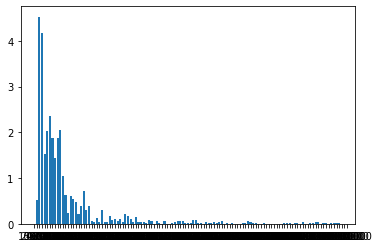

rank 12


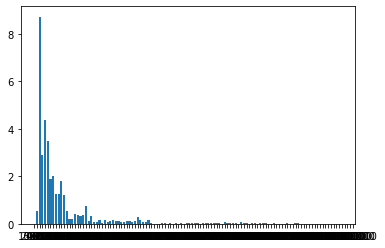

rank 20


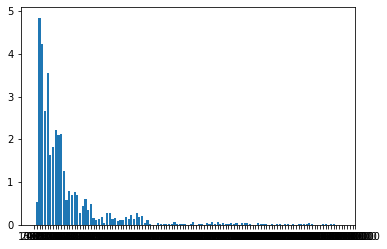

In [75]:
import math

selected_rank = [0, 4, 8, 12, 20]

plt.figure(figsize=(16,4))
for rank in selected_rank:
    io_df_rank = io_ddf_read_write[io_ddf_read_write['rank'] == rank]
    values = np.arange(0, math.ceil(job_time), time_step)
    values_int = range(len(values))
    timeline_ts = [0]*len(values_int)
    value_str = []
    prev = 0
    for i in values_int:
        value_str.append(str(values[i]))
        contains = (io_df_rank['tstart'] >=prev) & (io_df_rank['tend'] <values[i])
        timeline_ts[i] = io_df_rank[contains]['bandwidth'].mean()
        prev = values[i]
    print("rank {}".format(rank))
    plt.bar(value_str, timeline_ts)
    plt.show()

**Most I/O happens in the first 40 sec and most bandwidth is achieved from PFS**

#### Request Size Timeline per Rank

rank 0


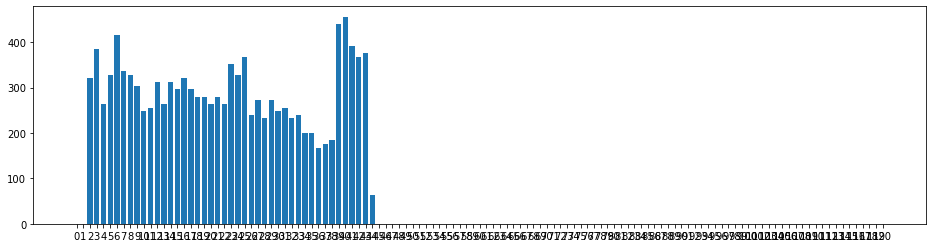

rank 4


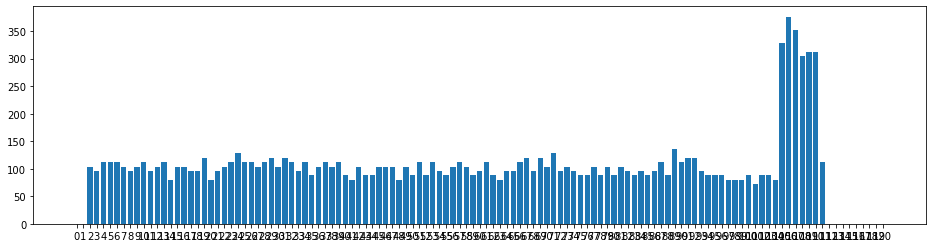

rank 8


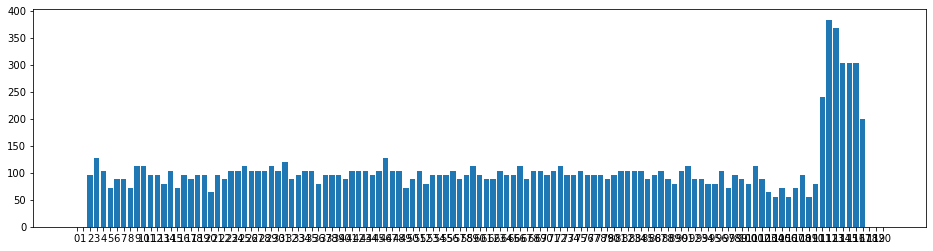

rank 12


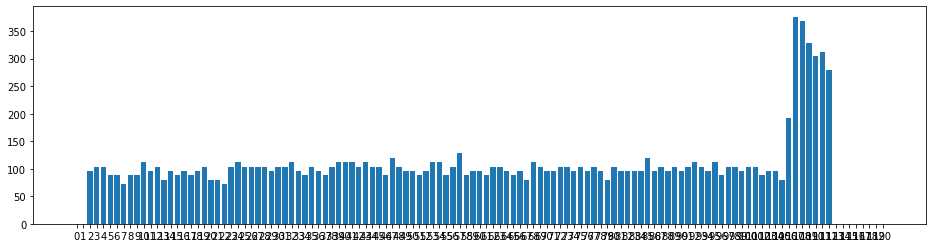

rank 20


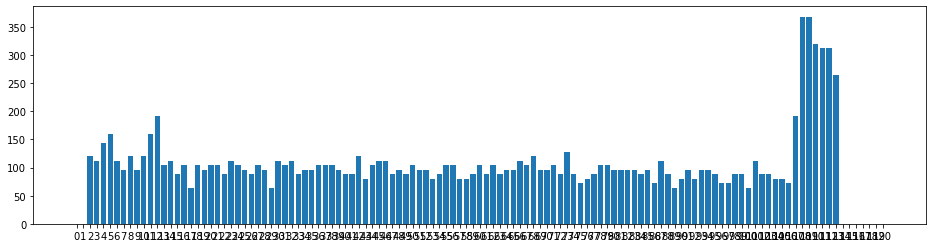

In [76]:
import math
selected_rank = [0, 4, 8, 12, 20]
for rank in selected_rank:
    io_df_rank = io_ddf_read_write[io_ddf_read_write['rank'] == rank]
    values = np.arange(0, math.ceil(job_time), time_step)
    values_int = range(len(values))
    timeline_ts = [0]*len(values_int)
    value_str = []
    prev = 0
    for i in values_int:
        value_str.append(str(i))
        contains = (io_df_rank['tstart'] >=prev) & (io_df_rank['tend'] <values[i])
        timeline_ts[i] = io_df_rank[contains]['size'].sum()/1024.0/1024.0
        prev = values[i]
    print("rank {}".format(rank))
    plt.figure(figsize=(16,4))
    plt.bar(value_str, timeline_ts)
    plt.show()

**Only rank 0 does I/O throughout the time. Rest perform read in first 40 seconds and perform computations.** 

## Find file which are independent or shared
- Make all thread id start from 0 and unique across ranks
- Group by filename nunique thread_id
- Find all filename with nunique > 1

In [77]:
thread_index_series = io_ddf.groupby(['rank', 'thread_id'])['thread_id'].nunique().cumsum().compute()

In [78]:
io_ddf['thread_index'] = 0
for index,item in thread_index_series.iteritems():
    condition = (io_ddf['rank'] == index[0]) & (io_ddf['thread_id'] == index[1])
    io_ddf['thread_index'] = io_ddf['thread_index'].mask(condition , item - 1)

In [79]:
threads = io_ddf['thread_index'].nunique().compute()
print("We have {} threads across {} ranks".format(threads, num_ranks))

We have 680 threads across 126 ranks


In [80]:
filename_series = io_ddf[io_ddf['filename'].str.contains('/p/gpfs1')].groupby(['filename'])['thread_index'].nunique().compute()

In [81]:
independent_files = filename_series[filename_series == 1]
print("{} files that are accessed by application by only one rank".format(len(independent_files)))

0 files that are accessed by application by only one rank


In [82]:
shared_files = filename_series[filename_series > 1]
print("{} files that are accessed by application by more than one rank".format(len(shared_files)))

49664 files that are accessed by application by more than one rank


This application doesnt share files. That is it follows a File per process pattern.

### Data Flow
We plot how different ranks in the job are accessing data.

In [83]:
import graphviz
dot = graphviz.Digraph()
selected_indices = range(4)
for selected_index in selected_indices:
    selected_shared_file = shared_files.index[selected_index]
    io_access_rank = io_ddf[io_ddf['filename'] == selected_shared_file].groupby(['rank','func_id'])['func_id'].count().compute()
    dot.node(selected_shared_file)
    for index,item in io_access_rank.iteritems():
        rank = index[0]
        func_id = index[1]
        count = item
        dot.node(str(rank))
        dot.node(func_id)
        dot.edge(str(rank),func_id)
        if "read" in func_id:
            dot.edge(selected_shared_file, func_id, label=str(count))
        else:
            dot.edge(func_id,selected_shared_file, label=str(count))

In [84]:
dot

In [85]:
import graphviz
dot = graphviz.Digraph()
selected_indices = [0]
for selected_index in selected_indices:
    if len(independent_files) > selected_index:
        selected_file = independent_files.index[selected_index]
        io_access_rank = io_ddf[io_ddf['filename'] == selected_file].groupby(['rank','func_id'])['func_id'].count().compute()
        dot.node(selected_file)
        for index,item in io_access_rank.iteritems():
            rank = index[0]
            func_id = index[1]
            count = item
            dot.node(str(rank))
            dot.node(func_id)
            dot.edge(str(rank),func_id)
            if "read" in func_id:
                dot.edge(selected_file, func_id, label=str(count))
            else:
                dot.edge(func_id,selected_file, label=str(count))

In [86]:
dot

## Calculate Access Pattern
- Calculate segment_index
  - select file_ptr based on open flag
  - update file_ptr based on operation
  - do a cum_sum on file_ptr to calculate final file_ptr
  - assign segment_index based on granularity (median transfer size)
- isolate segment index into
  - sequential flag if segment index is increasing
  - consequitive flag if segment index is increasing and one after the other

#### Persist the current version of I/O dataframe.

In [87]:
io_ddf = io_ddf.persist()
result = wait(io_ddf)

### Select files which have no seeks and those which have

In [88]:
files_with_seek = io_ddf[io_ddf['func_id'].str.contains('seek') & io_ddf['filename'].str.contains('/p/gpfs')]['filename'].unique().compute()
print("{} files have seek operations".format(len(files_with_seek)))

0 files have seek operations


In [89]:
files_with_seek

Series([], Name: filename, dtype: object)

In [90]:
all_filenames

0        /p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...
1        /p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...
2        /p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...
3        /p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...
4        /p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...
                               ...                        
49659    /p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...
49660    /p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...
49661    /p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...
49662    /p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...
49663    /p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...
Name: filename, Length: 49664, dtype: object

In [91]:
files_without_seek = set(all_filenames) - set(files_with_seek)
print("{} files have no seek operations and hence are sequential".format(len(files_without_seek)))

49664 files have no seek operations and hence are sequential


### Per File Analysis
- Total I/O amount
- Total I/O time (average per process)
- Average Bandwidth
- I/O Request Distribution

In [92]:
per_file_size = io_ddf_read_write.groupby(['filename'])['size'].sum()
per_file_size = per_file_size / 1024.0/1024.0
per_file_size = per_file_size.sort_values(ascending=False)
per_file_size.head(5)

filename
/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a730053_0_0_0_float.hdf5      32.311684
/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a880047_0_0_0_float.hdf5      32.311684
/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10000668_0_0_0_float.hdf5    32.311684
/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10754948_3_1_0_float.hdf5    32.009834
/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10754948_2_2_3_float.hdf5    32.009834
Name: size, dtype: float64

In [93]:
per_file_time = io_ddf_read_write.groupby(['filename'])['duration'].sum().sort_values(ascending=False)
per_file_time.head(5)

filename
/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1002673_2_1_0_float.hdf5     27.500
/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10726038_3_1_0_float.hdf5    23.625
/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a7322150_0_1_1_float.hdf5     19.000
/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10917364_2_1_1_float.hdf5    14.000
/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10170538_3_1_1_float.hdf5    13.125
Name: duration, dtype: float32

In [94]:
per_file_bw = io_ddf_read_write.groupby(['filename'])['bandwidth'].sum().sort_values(ascending=True)
per_file_bw.head(5)

filename
/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10582067_3_3_2_float.hdf5    0.0
/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a8811618_0_0_2_float.hdf5     0.0
/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10217838_1_2_1_float.hdf5    0.0
/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a8811618_0_0_1_float.hdf5     0.0
/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10217838_1_2_3_float.hdf5    0.0
Name: bandwidth, dtype: float64

In [95]:
import graphviz
dot = graphviz.Digraph()
selected_indices = [0]
for selected_index in selected_indices:
    selected_file = per_file_size.index[selected_index]
    io_access_rank = io_ddf[io_ddf['filename'] == selected_file].groupby(['rank','func_id'])['func_id'].count().compute()
    dot.node(selected_file)
    for index,item in io_access_rank.iteritems():
        rank = index[0]
        func_id = index[1]
        count = item
        if "read" in func_id or "write" in func_id:
            dot.node(str(rank))
            dot.node(func_id)
            dot.edge(str(rank),func_id)
            if "read" in func_id:
                dot.edge(selected_file, func_id, label=str(count))
            elif "write" in func_id:
                dot.edge(func_id,selected_file, label=str(count))

In [96]:
dot

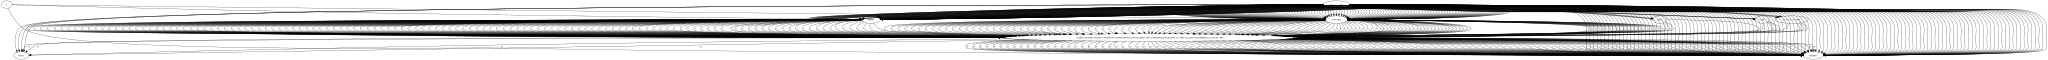

In [97]:
import graphviz
dot = graphviz.Digraph()
selected_file = shared_files.index[0]
io_access_rank = io_ddf[io_ddf['filename'] == selected_file].groupby(['rank','func_id'])['func_id'].count().compute()
dot.node(selected_file)
for index,item in io_access_rank.iteritems():
    rank = index[0]
    func_id = index[1]
    count = item
    if rank == 0:
        dot.node(str(rank))
    else:
        rank = "0,1,2,...127"
    dot.node(func_id)
    dot.edge(str(rank),func_id)
    if "read" in func_id:
        dot.edge(selected_file, func_id, label=str(count))
    else:
        dot.edge(func_id,selected_file, label=str(count))
dot

In [98]:
import graphviz
dot = graphviz.Digraph()
selected_indices = [0]
for selected_index in selected_indices:
    selected_file = per_file_time.index[selected_index]
    io_access_rank = io_ddf[io_ddf['filename'] == selected_file].groupby(['rank','func_id'])['func_id'].count().compute()
    dot.node(selected_file)
    for index,item in io_access_rank.iteritems():
        rank = index[0]
        func_id = index[1]
        count = item
        dot.node(str(rank))
        dot.node(func_id)
        dot.edge(str(rank),func_id)
        if "read" in func_id:
            dot.edge(selected_file, func_id, label=str(count))
        else:
            dot.edge(func_id,selected_file, label=str(count))

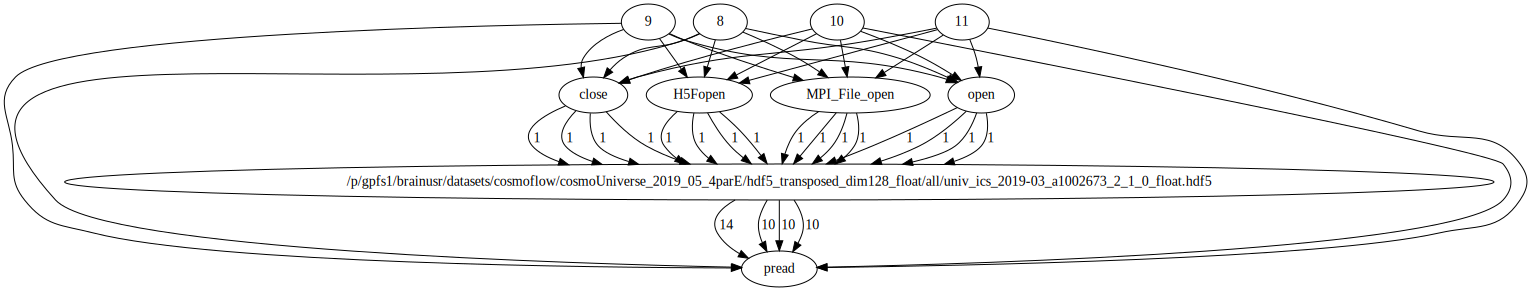

In [99]:
dot

In [100]:
import graphviz
dot = graphviz.Digraph()
selected_indices = range(5)
for selected_index in selected_indices:
    selected_file = per_file_bw.index[selected_index]
    io_access_rank = io_ddf[io_ddf['filename'] == selected_file].groupby(['rank','func_id'])['func_id'].count().compute()
    dot.node(selected_file)
    for index,item in io_access_rank.iteritems():
        rank = index[0]
        func_id = index[1]
        count = item
        dot.node(str(rank))
        dot.node(func_id)
        dot.edge(str(rank),func_id)
        if "read" in func_id:
            dot.edge(selected_file, func_id, label=str(count))
        else:
            dot.edge(func_id,selected_file, label=str(count))

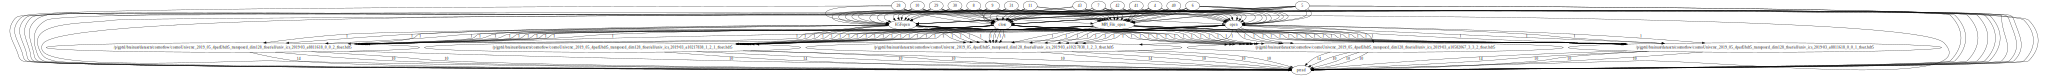

In [101]:
dot

In [102]:
write_files = io_ddf_read_write[io_ddf_read_write['func_id'].str.contains('write')]['filename'].unique()
read_files = io_ddf_read_write[io_ddf_read_write['func_id'].str.contains('read')]['filename'].unique()
read_only_files = set(all_filenames) - set(write_files)
write_only_files = set(all_filenames) - set(read_files)
print("{} files are written into.\n{} file are read from.\n{} files are write-only.\n{} file are read-only."
      .format(len(write_files), len(read_files), len(write_only_files), len(read_only_files)))

4 files are written into.
49668 file are read from.
0 files are write-only.
49664 file are read-only.


In [103]:
print(read_only_files)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [104]:
io_per_file = io_ddf_read_write[io_ddf_read_write['filename'].isin(read_only_files)].groupby(['filename'])['size'].sum()
io_per_file = io_per_file / 1024.0/1024.0
print(io_per_file)

filename
/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10000668_0_0_0_float.hdf5    32.311684
/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10000668_0_0_1_float.hdf5    32.009834
/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10000668_0_0_2_float.hdf5    32.009834
/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10000668_0_0_3_float.hdf5    32.009834
/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10000668_0_1_0_float.hdf5    24.006935
                                                                                                                                                   ...    
/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4p

In [105]:
io_per_file = io_ddf_read_write[io_ddf_read_write['filename'].isin(write_files) & io_ddf_read_write['func_id'].str.contains("write")].groupby(['filename'])['size'].sum()
io_per_file = io_per_file / 1024.0/1024.0
print(io_per_file.head(20))

filename
/dev/infiniband/uverbs0    0.140717
/dev/infiniband/uverbs1    1.712440
/dev/infiniband/uverbs2    0.984558
/dev/infiniband/uverbs3    0.144333
Name: size, dtype: float64


In [106]:
data_ops = ['read', 'write']
total_time_io_data = io_ddf[io_ddf['func_id'].isin(data_ops)].groupby('rank')['duration'].sum().max().compute()
total_time_io_metadata = io_ddf[~io_ddf['func_id'].isin(data_ops)].groupby('rank')['duration'].sum().max().compute()
print("Time spent on data: {} sec, metadata: {} sec".format(total_time_io_data, total_time_io_metadata))

Time spent on data: 0.63177490234375 sec, metadata: 400.6292724609375 sec
